In [2]:
# from surprise import BaselineOnly
# from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import AlgoBase


from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF, TruncatedSVD
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

import math
# from multiprocessing import Pool

In [2]:
from platform import python_version

print(python_version())

3.8.13


# Rating Data Overwrite for 'userfixed' data split feature.

Splitting the data using the userfixed method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.m

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    
    def cross_validate(self, n_splits=5):

        user_ratings = self.list_users_ratings(self.rating_mat)
        len_user_ratings = {u:len(user_ratings[0]) for u in range(self.user_n)}
        user_indices = {}
        for u in range(self.user_n):
            indices = list(range(len_user_ratings[u]))
            random.shuffle(indices)
            user_indices[u] = indices

        
        user_start = {}
        user_stop = {}
        for u in range(self.user_n):
            user_start[u] = 0
            user_stop[u] = 0


        for fold_i in range(n_splits):
            train_mat = sparse.lil_matrix((self.user_n, self.item_n))
            user_tests = {}

            for u in range(self.user_n):
                user_start[u] = user_stop[u]
                user_stop += len_user_ratings[u] // n_splits
                if fold_i < len_user_ratings[u] % n_splits:
                    user_stop += 1
                
                train_set_indices = user_indices[u][:user_start[u]] + user_indices[u][user_stop[u]:]
                test_set_indices = user_indices[u][user_start[u]:user_stop[u]]

                for ir_idx in train_set_indices:
                    ir = user_ratings[u][ir_idx]
                    train_mat[u, ir[0]] = ir[1]
                
                user_tests[u] = []
                for ir_idx in test_set_indices:
                    ir = user_ratings[u][ir_idx]
                    user_tests[u].append(ir)

            yield train_mat, user_tests
                



# Data import

In [4]:
df = pd.read_csv('ml-100k/udata.csv', 
                 sep=";", header=0, engine="python")

user = pd.read_csv('ml-100k/uuser.csv', 
                   sep=";", header=0, engine ="python")

genre = pd.read_csv('ml-100k/ugenre.csv', 
                    sep=";", header=0, engine = "python")

In [5]:
user.head()

,id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


# dimentionality reduction

In [6]:
n_core = 45  # minimal number of ratings

In [7]:
filter_items = df['item'].value_counts() > 45

In [8]:
# To reduce the dimensionality of the dataset,
# we will filter out rarely rated movies and rarely rating users

min_ratings = n_core
min_user_ratings = n_core

init_df = df
init_shp = df.shape[0]
filt_shp = 0.0

while True:

    filter_items = init_df['item'].value_counts() > min_ratings
    filter_items = filter_items[filter_items == True].index.tolist()

    filter_users = init_df['user'].value_counts() > min_user_ratings
    filter_users = filter_users[filter_users == True].index.tolist()

    filt_df = init_df[(init_df['item'].isin(filter_items)) & (init_df['user'].isin(filter_users))]

    print('The original data frame shape:\t{}'.format(init_df.shape))
    print('The new data frame shape:\t{}'.format(filt_df.shape))
    print()
    
    init_shp = init_df.shape[0]
    filt_shp = filt_df.shape[0]
    
    # print(init_shp, filt_shp)
    
    if (init_shp == filt_shp):
        break
    
    init_df = filt_df

    
#------------------------------------------------------------
'Updating the df to its filtered version'
'Now filt-df is called df.' 
df = filt_df
print(filt_df.shape)
print(df.head())

print()
print('#users: ', np.unique(df['user']).shape)
print('#items: ', np.unique(df['item']).shape)

The original data frame shape:	(100000, 3)
The new data frame shape:	(76420, 3)

The original data frame shape:	(76420, 3)
The new data frame shape:	(73656, 3)

The original data frame shape:	(73656, 3)
The new data frame shape:	(73003, 3)

The original data frame shape:	(73003, 3)
The new data frame shape:	(72690, 3)

The original data frame shape:	(72690, 3)
The new data frame shape:	(72600, 3)

The original data frame shape:	(72600, 3)
The new data frame shape:	(72600, 3)

(72600, 3)
   user  item  rating
1   186   302       3
3   244    51       2
5   298   474       4
6   115   265       2
7   253   465       5

#users:  (551,)
#items:  (593,)


In [9]:
df.to_csv('./filtered_ml_%icore.csv'%n_core, sep=',', index=False)

# Split into test and train with the 'userfixed' method

In [10]:
# data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

dataset = RatingDataset()
data_fn = './filtered_ml_%icore.csv'%n_core
dataset.read_from_file(data_fn, skip_lines=1, line_format='user item rating', sep=',')


print('# users', dataset.user_n)
print('# items', dataset.item_n)


# user_tests is the test_mat
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)


# ir = the pair of (item, rating)
# ir = user_ratings[user_iid][ir_idx]
user_ratings = dataset.list_users_ratings(dataset.rating_mat)
print(dataset.rating_mat.shape)


# users 551
# items 593

Number of users with some items in testset: 551
Number of ratings in trainset: 58307 	 Number of ratings in testset: 14293

(551, 593)


# convert train and test into dataframes

## train set

In [11]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]
# train_df = pd.DataFrame(columns = ['item','rating'])


tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    

train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']
train_df.head()

,user,item,rating
0,0,1,4.0
1,0,4,3.0
2,0,5,2.0
3,0,10,3.0
4,0,19,3.0


## test set

In [12]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']
test_df.head()

,user,item,rating
0,0,82,3.0
1,0,236,3.0
2,0,452,4.0
3,0,488,3.0
4,0,529,3.0


# SVD, and how to prepare data into a format readbale for Surprise

if you want to add back items, you can add them back to the dataframe and build th train again as below.

In [ ]:
tstart = datetime.now()

reader = Reader(rating_scale=(1, 5))
oracle_SVD = SVD()

rmse_lst = []

# build the train into surprise format
trainset_all = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader).build_full_trainset()

# build test set into surpirse format
testset_all = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

# fit 
oracle_SVD.fit(trainset_all)

# predictions
fin_preds = oracle_SVD.test(testset_all)

# get the RMSE
fin_acc = accuracy.rmse(fin_preds, verbose=False)

# print
print(fin_acc)

tend = datetime.now()    
print("\n in ms : \n")
print(tend-tstart)


# Accuracy metrics

In [13]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


# Non-negtive Matrix Factorization

## choose the topk function

In [43]:
def recNMF_2(user_iid, _est, mat, topk):
    
    rated_before = np.nonzero(mat[user_iid, :])[1]
    estimations = _est[user_iid]
    estimations[rated_before] = 0 
    # you don't want to recommend the items to the user that have rated before duh!
    
    # top_items = np.argpartition(-estimations, topk)[:topk]
    top_items = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]
    
    return (user_iid, top_items, top_ratings)

## making the predictions by multiplying the components

In [44]:
start = timeit.default_timer()
from sklearn.decomposition import NMF
feature_n = 40

mf = NMF(n_components=feature_n, init='random', random_state=2, tol=0.01,
         solver='cd', max_iter=1000, alpha=1, beta_loss='frobenius',
         l1_ratio=0)


user_f = mf.fit_transform(train_mat)
H = mf.components_
item_f = mf.components_.T


stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))
start = timeit.default_timer()
est = np.dot(user_f, item_f.T)
res = []

# Choose it to be 1000 instead of 10, and then the re-ranker will chose the final top 10
for u in range(dataset.user_n):
    res.append(recNMF_2(u, est, train_mat, 200))
    
user_recs_allinclude = {}
for x in res:
    user_recs_allinclude[x[0]] = x[1]

c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Process Time: 0.24 secs


## saving the base recommendaitons: give it a new path

In [45]:
u_rec_list = []
for i in range(len(res)):
    base_rec = pd.DataFrame(res[i][1:]).T
    base_rec[2] = res[i][0]
    u_rec_list.append(base_rec[[2,0,1]])

u_rec_df = pd.concat(u_rec_list, ignore_index=True)

# u_rec_df.to_csv('./ml_results/nmf_base_rec_ML_.csv', index=False, header=None)

## Evaluation

In [46]:
stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

p = []
r = []
n = []

for u in test_mat.keys():
    if len(test_mat[u]) > 0:
        
        test_items = [t[0] for t in test_mat[u] if t[1] >= 4]
        
        if len(test_items) > 0:
            # to be comparable with the other algorithms, the list size should be the same that is 10 here.
            top_items = user_recs_allinclude[u][:10] 
            
            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            p.append(precision)
            r.append(recall)
            n.append(ndcg)

print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f" %
       (np.average(p),np.average(r),np.average(n)))

Process Time: 3.80 secs
 avg-precision 0.309
 avg-recall 0.235
 avg-nDCG 0.149


# Active Learning

In [47]:
class PredictionBasedActiveLearner:

    def __init__(self, decomposer, strategy, initial_train_df=None):
        '''
        Prediction-based active learner class.

        Args:
            decomoser:        sklearn.decomposition, decomposition algorithm to be used 
                                                     to decompose rating matrix.
            strategy:         str, active learning strategy, 
                                   one of ('MaxRating', 'MinRating', 'MixRating').
            initial_train_df: DataFrame, initial training DataFrame.
        '''

        self.decomposer = decomposer
        self.strategy = strategy
        self.user_f = None
        self.item_f = None 
        self.est = None

        # remember unavailable queries (kind of cheating?)
        # self.unavl = {i: [] for i in range(dataset.user_n)}

        if initial_train_df is not None:
            self.known_mat = self._convert_df_to_mat(initial_train_df)

            self.user_f = self.decomposer.fit_transform(self.known_mat)
            self.item_f = self.decomposer.components_.T
            self.est = np.dot(self.user_f, self.item_f.T)

        else:
            self.known_mat = sparse.lil_matrix((dataset.user_n, dataset.item_n))

    def _convert_df_to_mat(self, df):
        '''
        Convert DaraFrame to sparse matrix
        
        Arg:
            df: DataFrame, training DataFrame
        
        Return:
            mat: lil_matrix, sparse matrix containing training data
        '''

        mat = sparse.lil_matrix((dataset.user_n, dataset.item_n))
        for _, row in df.iterrows():
            user_iid = int(row[0])
            item_iid = int(row[1])
            rating = row[2]
            mat[user_iid, item_iid] = rating
        
        return mat 

    def add_query(self, query_df):
        '''
        Add queried data to known matrix.
        
        Arg:
            query_df: DataFrame, new data to be added.
        '''

        for _, row in query_df.iterrows():
            user_iid = int(row[0])
            item_iid = int(row[1])
            rating = row[2]
            self.known_mat[user_iid, item_iid] = rating

    def train(self):
        '''
        Fit self.decomposer to known data.
        '''
        if self.decomposer == 'NMF':
            self.user_f = self.decomposer.fit_transform(self.known_mat)
            self.item_f = self.decomposer.components_.T

            self.est = np.dot(self.user_f, self.item_f.T)

        # return self to enable learner.train().predict()
        # return self
    
    def predict(self, user_iid, item_iid):
        '''
        Estimate rating of user and item pair.

        Args:
            user_iid: int, inner id of the user to be predicted
            item_iid: int, inner id of the item to be predicted
        
        Return:
            float
        '''

        return self.est[user_iid, item_iid]
    
    def query(self, user_iid, topk):
        '''
        Find the indices of candidates which should be queried for true ratings.

        Args:
            user_iid: int, inner id of the user to be queried
            topk:     int, number of queried candidates
        
        Return:
            (top_items, top_ratings): (numpy int array, numpy float array)
        '''
        
        rated_before = np.nonzero(self.known_mat[user_iid, :])[1]
        # unavailable = self.unavl[user_iid]
        
        estimations = self.est[user_iid]
        estimations[rated_before] = 0
        # estimations[unavailable] = 0

        if self.strategy == 'MaxRating':
            # query the top 10 highest predicted ratings for each user
            
            top_items = np.argsort(-estimations)[:topk]    # argsort sorts in increasing order
            top_ratings = -np.sort(-estimations)[:topk] # revert to original ratings

        elif self.strategy == 'MinRating':
            top_items = np.argsort(estimations)[:topk]
            top_ratings = np.sort(estimations)[:topk]
        
        else:
            k = int(topk/2)
            low_items = np.argsort(estimations)[:topk-k]
            low_ratings = np.sort(estimations)[:topk-k]
            
            high_items = np.argsort(-estimations)[:k]
            high_ratings = -np.sort(-estimations)[:k]

            top_items = np.concatenate((low_items, high_items))
            top_ratings = np.concatenate((low_ratings, high_ratings))
        
        return (top_items, top_ratings)
    
    def recommend(self, user_iid, topk):
        '''
        Find the indices of items which should be recommended to a user. This 
        is the same as query under MaxRating, but used in the evaluation.

        Args:
            user_iid: int, inner id of the user getting recommendations.
            topk:     int, number of recommended items.

        Return:
            (user_iid, top_items, top_ratings): (int, numpy int array, numpy float array)
        '''
        
        rated_before = np.nonzero(self.known_mat[user_iid, :])[1]
        estimations = self.est[user_iid]
        estimations[rated_before] = 0

        top_items = np.argsort(-estimations)[:topk]
        top_ratings = -np.sort(-estimations)[:topk]

        return (user_iid, top_items, top_ratings)



## Get initial training dataframe

In [48]:
def rating_dic_to_df(rating_dic):
    lst = []

    for user_iid in range(dataset.user_n): 
    
        if rating_dic[user_iid]:
            res = pd.DataFrame(rating_dic[user_iid])
            res[2] = user_iid

            lst.append(res[[2,0,1]])
    

    df = pd.concat(lst, ignore_index=True)
    df.columns = ['user','item','rating']
    return df

In [49]:
initial_n = 5
candidate_user_ratings = dataset.list_users_ratings(train_mat)
initial_user_ratings = {}

for user_iid in range(dataset.user_n):
    
    initial_user_ratings[user_iid] = []
    len_u = len(candidate_user_ratings[user_iid])
    
    if len_u >= initial_n:
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        selected_u = selected_u[:initial_n][:]

        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
    
    else: # number of ratings less than required initial number
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        
        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)

In [50]:
initial_train_df = rating_dic_to_df(initial_user_ratings)

In [51]:
print(initial_train_df.shape)
print('#users: ', np.unique(initial_train_df['user']).shape)
print('#items: ', np.unique(initial_train_df['item']).shape)

(2755, 3)
#users:  (551,)
#items:  (563,)


## Learning process

In [52]:
feature_n = 40
#mf = NMF(n_components=feature_n, init='random', random_state=2, tol=0.01,
#         solver='cd', max_iter=1000, alpha_W=1, alpha_H='same', beta_loss='frobenius',
#         l1_ratio=0)
mf = NMF(n_components=feature_n, init='random', random_state=0, max_iter=500, verbose=False)
learner = PredictionBasedActiveLearner(mf, 'MaxRating', initial_train_df)

In [ ]:
svd = TruncatedSVD(n_components=feature_n, algorithm='randomized')
learner = PredictionBasedActiveLearner(svd, 'MaxRating', initial_train_df)

In [62]:
epochs = 10
avg_recall_list = []
avg_precision_list = []
avg_ndcg_list = []
rmse_list = []

for epoch in range(epochs):
    for user_iid in range(dataset.user_n):
        
        # get the items to be queried
        query_item_lst = learner.query(user_iid, 10)[0]
        candidate_df_u = pd.DataFrame(candidate_user_ratings[user_iid])
        query_df = candidate_df_u.loc[candidate_df_u[0].isin(query_item_lst)].copy()
        query_df[2] = user_iid
        query_df = query_df[[2, 0, 1]]
        query_df.columns = [0, 1, 2]
        # add to known rating matrix
        learner.add_query(query_df)

        # remember the items that are unavailable
        # unavailable_item_lst = [i for i in list(query_item_lst) if i not in list(query_df[1])]
        # learner.unavl[user_iid] += unavailable_item_lst

    learner.train()

    # evaluation for the epoch
    res = []
    for u in range(dataset.user_n):
        res.append(learner.recommend(u, 10))
    
    user_recs_allinclude = {}
    for x in res:
        user_recs_allinclude[x[0]] = x[1]
    
    r_list = []
    p_list = []
    n_list = []

    test_ratings = []
    pred_test_ratings = []

    for u in test_mat.keys():
        if len(test_mat[u]) > 0:
            test_items = [t[0] for t in test_mat[u] if t[1] >= 4] # test items with ratings >= 4

            if len(test_items) > 0:
                top_items = user_recs_allinclude[u][:10]

                recall = Recall(test_items, top_items)
                precision = Precision(test_items, top_items)
                ndcg = nDCG_Time(test_items, top_items)

                r_list.append(recall)
                p_list.append(precision)
                n_list.append(ndcg)

                for t in test_mat[u]:
                    test_ratings.append(t[1])
                    pred_test_ratings.append(learner.predict(u, t[0]))
    
    avg_recall = np.average(r_list)
    avg_precision = np.average(p_list)
    avg_ndcg = np.average(n_list)
    rmse = math.sqrt(mean_squared_error(test_ratings, pred_test_ratings))
    
    avg_recall_list.append(avg_recall)
    avg_precision_list.append(avg_precision)
    avg_ndcg_list.append(avg_ndcg)
    rmse_list.append(rmse)


In [54]:
learner.known_mat

<551x593 sparse matrix of type '<class 'numpy.float64'>'
	with 20304 stored elements in List of Lists format>

In [55]:
learner.known_mat[0,507]

0.0

In [56]:
learner.est[0,507]

0.0

## Make the recommendations

In [57]:
res = []

for u in range(dataset.user_n):
    res.append(learner.recommend(u, 10))

In [58]:
user_recs_allinclude = {}
for x in res:
    user_recs_allinclude[x[0]] = x[1]

## Evaluation

### Ranking-based

In [61]:
p = []
r = []
n = []

for u in test_mat.keys():
    if len(test_mat[u]) > 0:
        test_items = [t[0] for t in test_mat[u] if t[1] >= 4] # test items with ratings >= 4

        if len(test_items) > 0:
            top_items = user_recs_allinclude[u][:10]

            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            r.append(recall)
            p.append(precision)
            n.append(ndcg)

print("Training epochs: %d" % epochs)
print(" avg-precision: %.3f\n avg-recall: %.3f\n avg-nDCG: %.3f" %
       (np.average(p),np.average(r),np.average(n)))

Training epochs: 10
 avg-precision: 0.181
 avg-recall: 0.131
 avg-nDCG: 0.085


### RMSE

In [ ]:
test_ratings = []
pred_test_ratings = []

for u in test_mat.keys():
    if len(test_mat[u]) > 0:
        for t in test_mat[u]:
            test_ratings.append(t[1])
            pred_test_ratings.append(learner.predict(u, t[0]))


rmse = math.sqrt(mean_squared_error(test_ratings, pred_test_ratings))

## Plotting the results

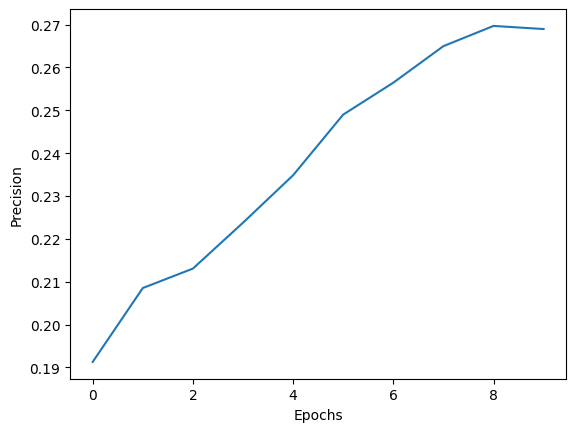

In [64]:
plt.plot(avg_precision_list)
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.show()